In [1]:
%run ./utility.ipynb

# Gradient Calculations: Finite Differences

We have two different methods of computing gradients and in this notebook we will explore the first one. 

## Gradient's Background
A gradient is vector where the direction is towards greatest rate of change when looking at a scalar function and the magnitude is the greatest rate of change. In our model, the gradient will be positive or negative depending on if a pixel's value must in increased or decreased. The gradient is vector where each pixel has its own component in the gradient.

Here's an intuitive way of looking at gradients: Image you are standing in Tucson at Alvernon and Grant and we are interested in the function f that tells you your elevation. The gradient of f will always tell you which direction you should travel in in order to rise in elevation the quickest.

We can use gradients to find local maximums and minimums by simply following the gradient until either the gradient is 0 or we never finish (in the event of infinity end behaviors).

Why are gradient's important? In the real world, gradients are used in many fields like physics, robotics, and optimizations. We use it all the time in order to quanify the net rate of change in multi-variable functions!

## Method one: Finite Differences Methods

The Finite Differences Method are a numerical analysis technique for solving differential equations by approximating derivatves using finite differences. Using these finite differences we can approximate a gradient of a function which we will denote as $\nabla f$.

So what is Finite Differences exactly? It is a mathematical expression of the form $f(x+b)-f(x+a)$.

There are three basic types that are commonly considered for this method: Forward, Backward, and Central.

Forward differences is calcuated by $\nabla f = \frac{f(x+h)-f(x)}{h}$

Backward differences is calcuated by $\nabla f = \frac{f(x) - f(x-h)}{h}$

Central differences is calcuated by $\nabla f = \frac{f(x+\frac{h}{2})-f(x-\frac{h}{2})}{h}$

### The Function Implemented

Below we have all three methods implemented controlled by a mode flag.

For Gradient Descent, we consider $f$ to be our loss function and h to be a minute difference from a pixel's value. We iterate over every pixel and calculate the loss needed for equation used ($f(x+h)$, $f(x-h)$, or $f(x+\frac{h}{2})-f(x-\frac{h}{2})$). This gives us the gradient for each pixel.


In [2]:
def gradient_finite_differences(data_list: list[data], coords, image, mode = 1, FOV = 100*u.uas.to(u.rad)):
    """
    Calculates a gradient based on finite differences
    Args:
        data_list is a list of data objects
        coords is a list of u,v coordinates that we obtained from our data
        image is a 80x80 pixel image that represents our reconstructed image
        mode is the type of difference used: 0 For central, -1 for backward, 1 for forward
        FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    Returns:
        the gradient of the loss function
    """
    image_copy = np.copy(image, subok=True)
    upper_diff: float
    lower_diff: float
    h: float
    gradient_arr = np.empty(np.shape(image),dtype=np.complex_)
    if (mode == 0): # Central difference
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-6 / 2
                upper_diff = loss(image_copy, data_list, coords, FOV=FOV)
                image_copy[row,col] -= 1e-6
                lower_diff = loss(image_copy, data_list, coords, FOV=FOV)
                image_copy[row,col] = image[row,col] # Reset that pixel to original value
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-6
    elif (mode == -1): # Backward difference
        upper_diff = loss(image, data_list, coords, FOV=FOV)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] -= 1e-8
                lower_diff = loss(image_copy, data_list, coords, FOV=FOV)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    elif (mode == 1) : # Forward difference is default
        lower_diff = loss(image, data_list, coords, FOV=FOV)
        for row in range(len(image)):
            for col in range(len(image[row])):
                image_copy[row,col] += 1e-8 
                upper_diff = loss(image_copy, data_list, coords, FOV=FOV)
                gradient_arr[row,col] = (upper_diff - lower_diff) / 1e-8
                image_copy[row,col] = image[row,col]
    else:
        raise ValueError('Incorrect mode for finite differences')
    return gradient_arr.real

Final Note: Why do we use 1e-6 and 1e-8.

When we want to estimate our loss function using the method below.

Consider the loss function f and we want to estimate it at point x as a finite difference. Additionally, let g be the numerical computation of f. Then we consider the analysis below

$$f'_h = max_{\Delta x} \frac{|\frac{g(x+\delta x + h) - g(x+\delta x)}{h} -f'(x)|}{|f'(x)|}|\frac{x}{\Delta x}|$$
$$\sim \frac{|g(x+h) - g(x) -f'(x)h|}{\epsilon_{machine}h|f'(x)|}$$
$$\sim\frac{\epsilon_{machine}f +(\frac{fh^2}{L^2})}{\frac{\epsilon_{machine}hf}{L}}$$
$$ = \frac{L}{h} + \frac{h}{\epsilon_{machine}L}$$

Here, L is a characteristic scale of x and $\epsilon_{machine}$ is the error of the machine. By minimizing $f'_h$ with respect to h, we find that $h \sim \sqrt{\epsilon_{machine}}L$. With $L\sim 1$, $h \sim \sqrt{\epsilon_{machine}}$.

Why don't we use other values of h? 

We have to balance between two types of errors: The first being the error due to numerical errors within g. As h becomes two small, the error becomes bigger. The other error is from the higher order derivatives of the function f. As h grows larger, the higher order derivatives start to dominate the approximation.

How does this connect to 1e-6 and 1e-8? 

Floats in Python use IEEE Double Precision format which gives allows for it to compare up to $10^{-16}$ precision between two values. In forward and backward differences, the $h$ value uses the square root of $10^{-16}$ which is $10^{-8}$. In central differences, the $h$ value uses a cubic root which means it uses roughly $10^{-6}$

### Demo Walkthrough

Start with an empty or blank image

(-0.5, 79.5, 79.5, -0.5)

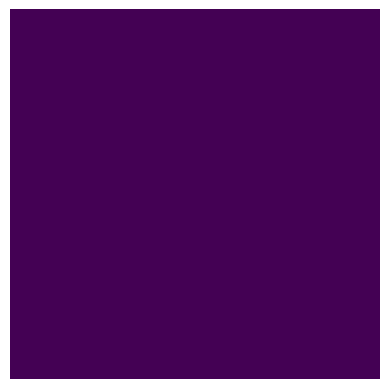

In [3]:
emp = np.zeros((80,80))
plt.figure()
plt.imshow(emp)
plt.axis('off')

Next we get the sample data points from our synthetic data. Afterwards we will run our gradient code.

(-0.5, 79.5, 79.5, -0.5)

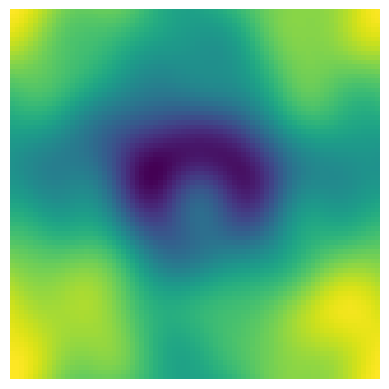

In [4]:
sample = np.loadtxt("images/data.csv", delimiter=",")
coords, data_list = do_sample(50)
x = gradient_finite_differences(data_list, coords, emp, FOV = 1)
plt.figure()
plt.imshow(x)
plt.axis('off')

Above is the image representation of the gradient, darker areas represent smaller gradients and lighter areas represent bigger gradients.

It is specifically a gradient when we start our "image" as an empty or blank image. The gradient above shows which pixels are different than what we would expect given a data set (whether some should be brighter, darker or stay the same). 

## Gradient Descent

Now that we have computed a gradient, we can now start doing gradient descent. Gradient Descent is an optimization algorithm for finding local minimum within a differentiable function. We can use this to find values of parameters that minimize some sort of cost function. Here, the parameters as simply each pixel in our image, and the cost functions that we are trying to minimize is the loss function.

Heres how it works. We first calcualte the loss at the current position. The algorithm then iteratively calculates the next image by using the gradient at the current position. We scale the gradient so that we can obtain a loss less than the current loss and then subtract the scaled gradient from the image. This is called a single step. We subtract the gradient because we are looking to minimise the function rather than maximizing it.

We take a bunch of these steps until we hit some stopping condition (here it is `np.min(np.abs(grad)) <= 0.0000001`).

The choosing of step size (the scaling of the gradient) is important because if not chosen properly, it will lead to this pattern called zig-zagging. This would then cause the program to reach the minimum slower than it would have by going on a straight path.

In [5]:
def gradient_descent(image, data_list, coords, coeffs = None, FOV = 100*u.uas.to(u.rad), stopper = None, dirty = False):
    """
    Performs gradient descent to reconstruct the image
    Args:
        image is a 80x80 pixel image that represents our reconstructed image
        data_list is a list of data objects
        coords is a list of u,v coordinates that we obtained from our data
        coeffs is the precomputed coefficients
        FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
        stopper allows the descent to stop at 20 iterations
        dirty changes the gradient mode to dirty kernel
    Returns:
        the reconstructed image
    """
    image_copy = np.copy(image, subok=True) # Uses copy of the image due to lists being mutable in python
    i = 0
    grad = None
    losses_arr = []
    # Can also use max here, min just makes it finish quicker
    while grad is None or np.min(np.abs(grad)) > 0.00001:
        t = 10000000 # Initial Step size which resets each iteration
        prev_loss = loss(image_copy, data_list, coords, FOV=FOV)

        if dirty:
            grad = dirty_gradient(data_list, coords, coeffs, image_copy)
        else:
            grad = gradient_finite_differences(data_list, coords, image_copy, FOV=FOV)

        new_image = image_copy - t * grad.real
        new_loss = loss(new_image, data_list, coords, FOV=FOV)
        
        while new_loss > prev_loss: # Only run when new_loss > prev_loss
            new_image = image_copy - t * grad.real
            new_loss = loss(new_image, data_list, coords, FOV=FOV)
            t /= 2

        image_copy -= t * 2 * grad.real # Multiply by 2 to undo last divide in the while loop
        i += 1
        if stopper != None:
            if i == stopper: # Hard stop here for notebook purposes
                break
        losses_arr.append(np.log(new_loss))

    time_step = [i for i in range(len(losses_arr))]
    plt.figure()
    plt.plot(time_step, losses_arr)
    plt.title("ln(loss) vs time")
    plt.ylabel("loss")
    plt.xlabel("time t")

    plt.show()
    return image_copy

Here is what the gradient descent's output looks like after just 15 iterations. The code should be ran using

    reconstructed_img = gradient_descent(emp, data_list, coords)

You will notices that the loss decreases very rapidly towards zero

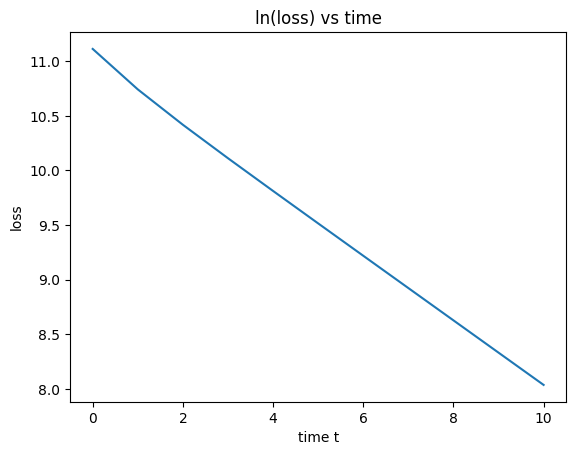

In [6]:
coords, data_list = do_sample(50)
reconstructed_img = gradient_descent(emp, data_list, coords, FOV = 1, stopper = 12)

Text(0.5, 1.0, 'Reconstructed Image')

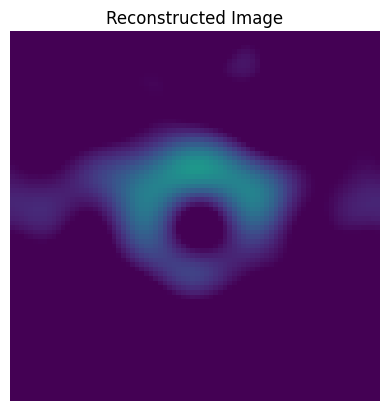

In [7]:
plt.figure()
plt.imshow(reconstructed_img, vmin=0, vmax=np.max(sample))
plt.axis('off')
plt.title("Reconstructed Image")

After another 20 iterations, you should see this:

Text(0.5, 1.0, 'Reconstructed Image')

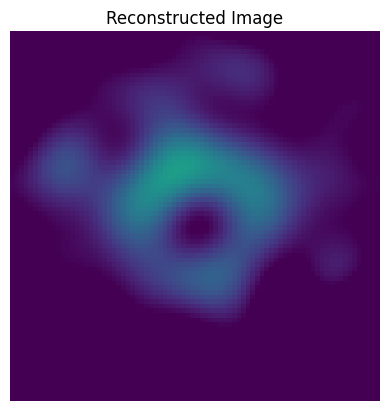

In [8]:
reconstructed_img = np.loadtxt("images/reconstructed_img_prev.csv", delimiter=",")
plt.figure()
plt.imshow(reconstructed_img, vmin=0, vmax=np.max(sample))
plt.axis('off')
plt.title("Reconstructed Image")

Here is the original image that the data was taken from

Text(0.5, 1.0, 'True Image')

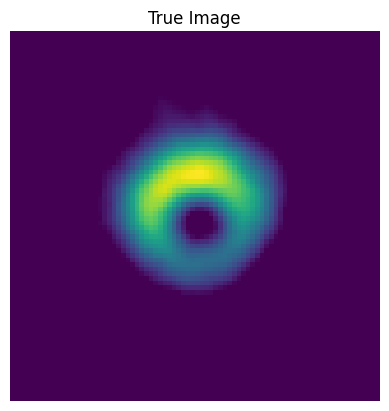

In [9]:
plt.figure()
plt.imshow(sample, vmin=0, vmax=np.max(sample))
plt.axis('off')
plt.title("True Image")

As you can see here, the reconstructed image doesn't replicate the original image directly but it will still reconstruct some of the big important features that EHT Analysis uses. Here we can see the general shape of the reconstructed image matches up with the original image

### Running gradient on Real EHT Data

Here is code to run this:

    df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
    coords, data_list = process_data(df)
    x = gradient_finite_differences(data_list, coords, emp)

(-0.5, 79.5, 79.5, -0.5)

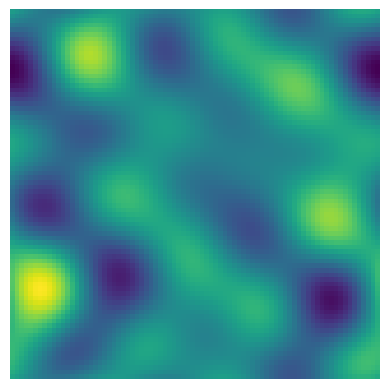

In [10]:
x = np.loadtxt("images/real_gradient.csv", delimiter= ",")
plt.figure()
plt.imshow(x)
plt.axis('off')